# Appendix - HW 4 Szymon Sadkowski

### 0. For the selected data set, train at least one tree-based ensemble model, e.g. random forest, gbdt, xgboost.

In [54]:
SEED = 42
TEST_SIZE = 0.2

In [55]:
from sklearn.datasets import fetch_openml

X, Y = fetch_openml('kc1', return_X_y=True)

/home/szysad/.virtualenvs/XAI-py3.9/lib64/python3.9/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning:

The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.



## Data split and testing models.

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC


models_dict = {
    'logistic_regression': LogisticRegression(random_state=SEED, max_iter=1000, n_jobs=-1),
    'random_forest': RandomForestClassifier(random_state=SEED, n_jobs=-1),
    'xgboost': XGBClassifier(random_state=SEED, n_jobs=-1),
    'svm': SVC(random_state=SEED, probability=True)
}

scaler_dict = {
    'logistic_regression': StandardScaler(),
    'random_forest': StandardScaler(),
    'xgboost': StandardScaler(),
    'svm': StandardScaler()
}


In [57]:
from typing import Tuple
import numpy as np


def prep_data(model_name, x, y) -> Tuple[np.ndarray, np.ndarray]:
    y_trans = LabelEncoder()
    y = y_trans.fit_transform(y)

    x_trans = scaler_dict[model_name]
    x = x_trans.fit_transform(x)

    return x, y

In [58]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV



def train_model(model_name):
    x, y = prep_data(model_name, X, Y)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=SEED)
    model = models_dict[model_name]
    grid_search = GridSearchCV(model, {}, scoring='roc_auc', cv=cv, n_jobs=-1)
    grid_search.fit(x, y)
    model = grid_search.best_estimator_
    print(f"Model: {model_name}, performance: {grid_search.best_score_}")
    return model


In [59]:
models = dict()

for model_name in reversed(models_dict.keys()):
    models[model_name] = train_model(model_name)

Model: svm, performance: 0.6908670671327644
Model: xgboost, performance: 0.7886413672616581
Model: random_forest, performance: 0.8260059891272715
Model: logistic_regression, performance: 0.8023506731206665


### 1. Calculate Permutation-based Variable Importance for the selected model.

In [60]:
def model_predict(model, data):
    return model.predict_proba(data.to_numpy())[:, 1]

In [108]:
import dalex as dx
import pandas as pd


trans_x, trans_y = prep_data("xgboost", X, Y)
trans_x = pd.DataFrame(trans_x, columns=X.columns)
trans_y = pd.DataFrame(trans_y, columns=["prediction"])


explainer = dx.Explainer(models["xgboost"], trans_x, trans_y, predict_function=model_predict, label="xgb")

Preparation of a new explainer is initiated

  -> data              : 2109 rows 21 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 2109 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7feac1e0c820> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.000667, mean = 0.155, max = 0.997
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.584, mean = -4.81e-05, max = 0.981
  -> model_info        : package xgboost

A new explainer has been created!


In [62]:
pvi = explainer.model_parts(random_state=SEED)


In [63]:
pvi.plot()


### 2. Train three more candidate models (different variable transformations, different model architectures, hyperparameters) and compare their rankings of important features using PVI. What are the differences? Why?

In [103]:
explainers = dict()

explainers["xgboost"] = explainer

for model_name, model in models.items():
    if model_name == "xgboost":
        continue
    explainers[model_name] = dx.Explainer(model, trans_x, trans_y, predict_function=model_predict, label=model_name)

Preparation of a new explainer is initiated

  -> data              : 2109 rows 21 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 2109 values
  -> model_class       : sklearn.svm._classes.SVC (default)
  -> label             : svm
  -> predict function  : <function model_predict at 0x7feac2b861f0> will be used
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0259, mean = 0.155, max = 0.962
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.877, mean = -0.000517, max = 0.943
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 2109 rows 21 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> t

In [65]:
for exp in explainers.values():
    pvi = exp.model_parts(random_state=SEED)
    pvi.plot()

### 3. For the tree-based model from (1), compare PVI with: 

##### A) the traditional feature importance measures for trees: Gini impurity etc.; what is implemented in a given library: see e.g. the `feature_importances_` attribute in `xgboost` and `sklearn`.

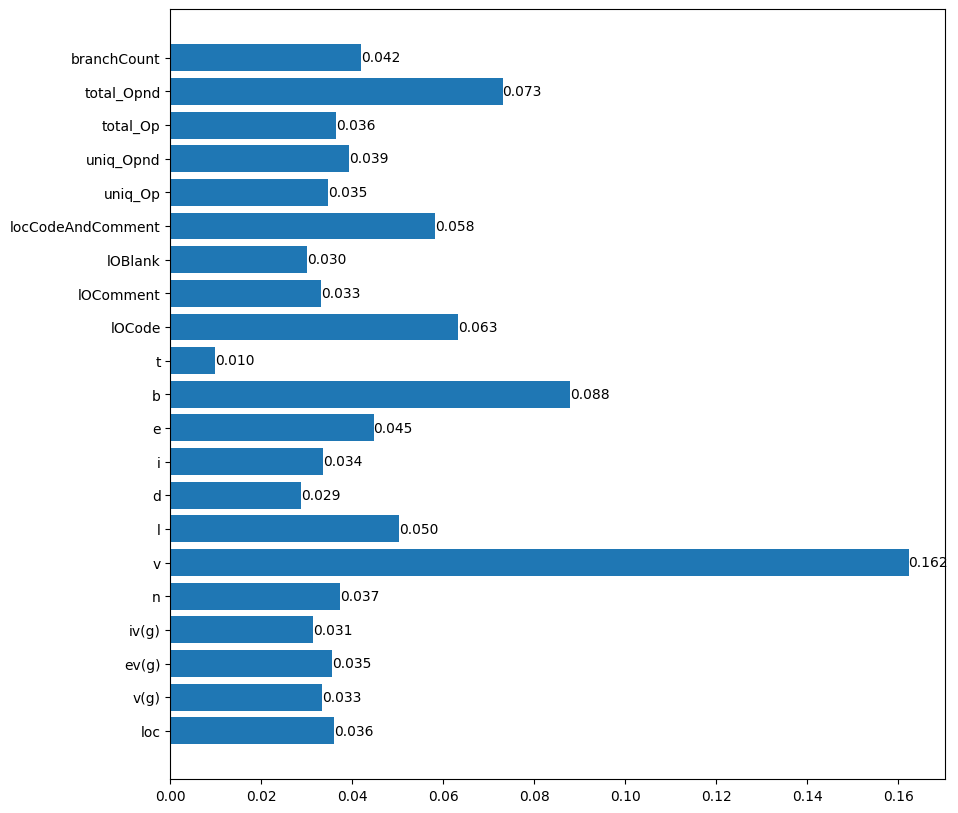

In [102]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10,10))
bars = ax.barh(X.columns, models["xgboost"].feature_importances_)
ax.bar_label(bars, fmt='{:,.3f}')
plt.show()


##### B) [in Python] SHAP variable importance based on the TreeSHAP algorithm available in the `shap` package. 

In [114]:
xgb_explainer = dx.Explainer(models["xgboost"], trans_x, trans_y, label="xgb")  # recreate without predict function
shap_vi = xgb_explainer.model_parts(type="shap_wrapper", shap_explainer_type="TreeExplainer")


Preparation of a new explainer is initiated

  -> data              : 2109 rows 21 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 2109 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : xgb
  -> predict function  : <function yhat_proba_default at 0x7feac1e0c820> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.000667, mean = 0.155, max = 0.997
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.584, mean = -4.81e-05, max = 0.981
  -> model_info        : package xgboost

A new explainer has been created!


[20:07:37] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


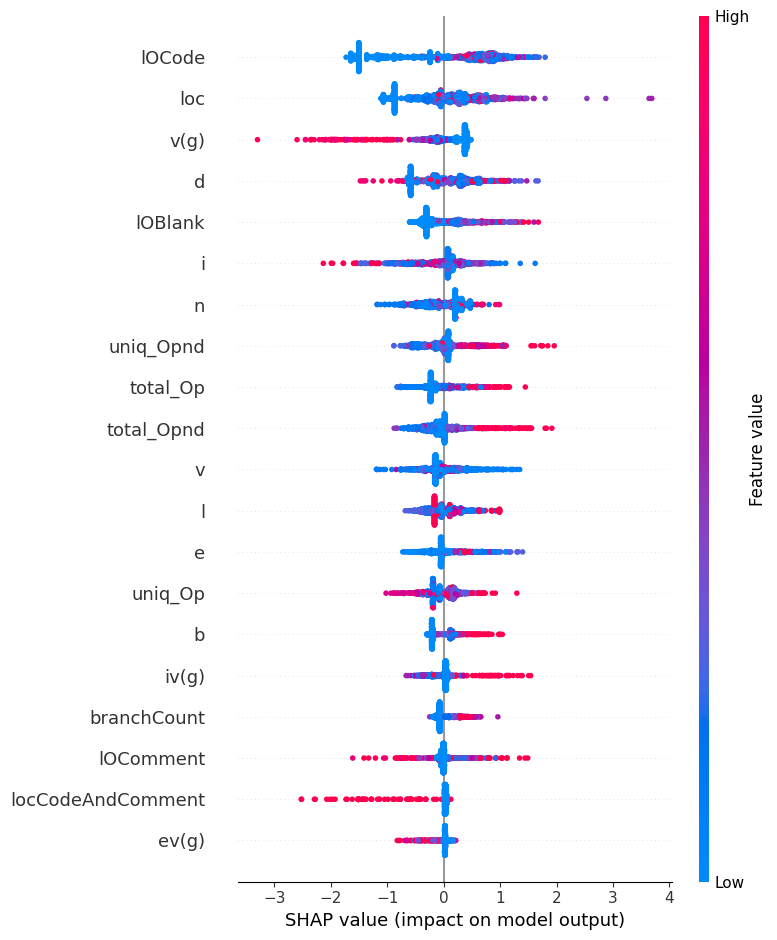

In [115]:
shap_vi.plot()